# Verification of TC Jasper risk matrix forecasts


This code is used to generate Figure 10 in the paper, including calculating the mean scores for each of the forecast sources.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import locally stored python modules
import my_functions as mf
import gamma_fitting as gf


In [2]:
# director where data is located.
DIR_DATA = 'data'

# severity thresholds, in terms of percentage AEP. Severity increases with decreasing threshold value.
AEP_PCT_THESHOLDS = [20, 10, 5]
# Severity category names
SEV_CATS = ('MOD+', 'SEV+', 'EXT')

# probability thresholds
PROB_THRESHOLDS = [.1, .3, .5]

# weight schemes for different warning scalings
WTS_LONGRANGE = np.array(  # lead day 0 warning
    [
        [0, 0, 0],  # high prob threshold
        [0, 0, 0],  # mid prob threshold
        [1, 0, 0],  # low prob threshold
    ]
)

WTS_MIDRANGE = np.array(  # lead day 1 warning
    [
        [0, 0, 1],  # high prob threshold
        [0, 1, 0],  # mid prob threshold
        [1, 0, 0],  # low prob threshold
    ]
)

WTS_SHORTRANGE = np.array(  # lead day 0 warning
    [
        [1, 1, 0],  # high prob threshold
        [0, 1, 1],  # mid prob threshold
        [1, 0, 1],  # low prob threshold
    ]
)

WTS_UNIFORM = np.array(
    [
        [1, 1, 1],  # high prob threshold
        [1, 1, 1],  # mid prob threshold
        [1, 1, 1],  # low prob threshold
    ]
)

WTS_ESCALATE = np.array(  # increasing weight for each higher colour
    [
        [2, 3, 0],  # high prob threshold
        [0, 2, 3],  # mid prob threshold
        [1, 0, 2],  # low prob threshold
    ]
)

In [3]:
# get all the data, convert obs into binary format

# get the forecast data
ecens = xr.open_dataarray(f'{DIR_DATA}/station_precipitation24h_ecmwf_ens_20231217.nc')
ecdet = xr.open_dataarray(f'{DIR_DATA}/station_precipitation24h_ecmwf_hres_20231217.nc')
acens = xr.open_dataarray(f'{DIR_DATA}/station_precipitation24h_bom_access_ge3_20231217.nc')

# get the AEP data
# The aep_pct dimension is the annual exceedance probability, expressed as a percentage
aeps = xr.open_dataset(f'{DIR_DATA}/aeps_at_stations.nc')
# get the AEP percent thresholds of interest and relabel them as severity thresholds
aeps = aeps.sel(aep_pct=AEP_PCT_THESHOLDS, method='nearest').rename({'aep_pct': 'sev_threshold'})

# get the observations (in millimetres) as a dataframe
obs = pd.read_csv(f'{DIR_DATA}/observations.csv')
# convert to an xarray data array
obs = obs[['valid_15z_date', 'station_number', 'precip']].set_index(['valid_15z_date', 'station_number']).to_xarray()['precip']

# make the observations binary
obs_mask = ~np.isnan(obs)
# 1 if exceeded AEP, 0 otherwise
binary_obs = (obs > aeps.rainfall_depth).astype(float)
binary_obs = binary_obs.where(obs_mask).sel(valid_15z_date='2023-12-17')


In [4]:
# function to calculate probability of exceedances

def poe_from_ensemble(fcst, aeps):
    """
    Gets probability of exceedance forecasts from an ensemble of forecasts.

    Args:
        fcst: xarray data array of forecasts.
        aeps: dataset of AEP thresholds
    
    """
    # make sure fcst and aeps have a common set of stations
    fcst = fcst.sel(station_number=aeps.station_number)

    # if 'realization' is not a dimension, it is a deterministic model
    if 'realization' not in fcst.dims:
        mask = ~np.isnan(fcst)
        poes = (fcst > aeps['rainfall_depth']).astype(float).where(mask)
    else:
        # number of ensemble members
        n_ens = len(fcst.realization)
        mask = fcst.count('realization') == n_ens
        # apply a gamma fit to the ensemble precipitation forecast
        fcst = mf.clip_small_amounts(fcst)
        pars = gf.hybridgamma_best_fit(fcst, point_dim='realization')
        # get the probability of exceedances from the fit
        poes = 1 - gf.hybridgamma_cdf(aeps['rainfall_depth'], pars)
        poes = poes.where(mask)
   
    return poes


In [5]:
# get the probability of exceedance forecasts
poe_ecens = poe_from_ensemble(ecens, aeps)
poe_ecdet = poe_from_ensemble(ecdet, aeps)
poe_acens = poe_from_ensemble(acens, aeps)
# PoE for the never warn forecast
poe_nil = xr.full_like(poe_acens, 0)  # the no warning forecast

# get the weight arrays
wt_longrange = mf.wt_matrix_to_xr(WTS_LONGRANGE, PROB_THRESHOLDS, AEP_PCT_THESHOLDS, sev_thresholds_descending=True)
wt_midrange = mf.wt_matrix_to_xr(WTS_MIDRANGE, PROB_THRESHOLDS, AEP_PCT_THESHOLDS, sev_thresholds_descending=True)
wt_shortrange = mf.wt_matrix_to_xr(WTS_SHORTRANGE, PROB_THRESHOLDS, AEP_PCT_THESHOLDS, sev_thresholds_descending=True)
wt_uniform = mf.wt_matrix_to_xr(WTS_UNIFORM, PROB_THRESHOLDS, AEP_PCT_THESHOLDS, sev_thresholds_descending=True)
wt_escalate = mf.wt_matrix_to_xr(WTS_ESCALATE, PROB_THRESHOLDS, AEP_PCT_THESHOLDS, sev_thresholds_descending=True)

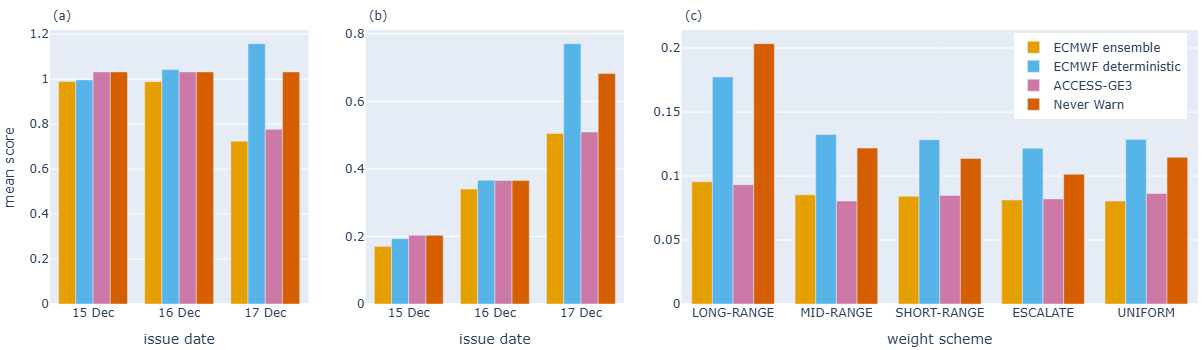

In [8]:
# Plot of mean scores in Section 4 of the paper

LEAD_DAY = 0  # lead day for weight scheme comparison in plot (c)

# Labels for the plot
issue_dates = ['15 Dec', '16 Dec', '17 Dec']
names_list = ['ECMWF ensemble', 'ECMWF deterministic', 'ACCESS-GE3', 'Never Warn']
colours_list = ["#E69F00", "#56B4E9", "#CC79A7", "#D55E00"]
weights = ['LONG-RANGE', 'MID-RANGE', 'SHORT-RANGE', 'ESCALATE', 'UNIFORM']

# uniform weights for plot (a)
wt_sequence0 = wt_uniform.copy()

# non-normalised weights for warning sequence in plot (b)
wt_sequence1 = xr.concat([
    wt_longrange.assign_coords(lead_day=2).expand_dims('lead_day'),
    wt_midrange.assign_coords(lead_day=1).expand_dims('lead_day'),
    wt_shortrange.assign_coords(lead_day=0).expand_dims('lead_day'),
], 'lead_day')

# normalised weights for lead day 0 in plot (c)
wt_sequence2 = xr.concat([
    wt_longrange.assign_coords(weight='watch').expand_dims('weight'),
    wt_midrange.assign_coords(weight='warning1').expand_dims('weight'),
    wt_shortrange.assign_coords(weight='warning0').expand_dims('weight'),
    wt_escalate.assign_coords(weight='escalate').expand_dims('weight'),
    wt_uniform.assign_coords(weight='all').expand_dims('weight'),
], 'weight')
# normalisation step
wt_sequence2 = wt_sequence2 / wt_sequence2.sum(['prob_threshold', 'sev_threshold'])

# scoring functions for each of the plots
def _scfunc0(fcst):
    """
    Risk matrix score with uniform weights (plot a)
    """
    result = mf.risk_matrix_score(
        fcst.sel(lead_day=slice(0,2)), 
        binary_obs, 
        wt_sequence0, 
        PROB_THRESHOLDS, 
        'sev_threshold'
    )
    return result

def _scfunc1(fcst):
    """
    Warning score for warning sequence (plot b)
    """
    result = mf.risk_matrix_score(
        fcst.sel(lead_day=slice(0,2)), 
        binary_obs, 
        wt_sequence1, 
        PROB_THRESHOLDS, 
        'sev_threshold'
    )
    return result

def _scfunc2(fcst):
    """
    Risk matrix scores using different weight schemes (plot b)
    """
    result = mf.risk_matrix_score(
        fcst.sel(lead_day=LEAD_DAY), 
        binary_obs, 
        wt_sequence2, 
        PROB_THRESHOLDS, 
        'sev_threshold'
    )
    return result

# get the mean scores
fcst_list = [poe_ecens, poe_ecdet, poe_acens, poe_nil]

scores0 = [_scfunc0(fcst) for fcst in fcst_list]
scores0 = [x.mean('station_number') for x in scores0]

scores1 = [_scfunc1(fcst) for fcst in fcst_list]
scores1 = [x.mean('station_number') for x in scores1]

scores2 = [_scfunc2(fcst) for fcst in fcst_list]
scores2 = [x.mean('station_number') for x in scores2]

################
# make the plot
fig = make_subplots(rows=1, cols=3, column_widths=[0.25, 0.25, 0.5], horizontal_spacing=0.05)

# values in plot (a)
for yvals, name, color in zip(scores0, names_list, colours_list):
        
        fig.add_trace(go.Bar(
            x=issue_dates,
            y=np.flip(yvals.values.flatten()),
            name=name,
            showlegend=False,
            marker_color=color
        ), row=1, col=1)

# values in plot (b)
for yvals, name, color in zip(scores1, names_list, colours_list):
        
        fig.add_trace(go.Bar(
            x=issue_dates,
            y=np.flip(yvals.values.flatten()),
            name=name,
            marker_color=color
        ), row=1, col=2)

# values in plot (c)
for yvals, name, color in zip(scores2, names_list, colours_list):
        
        fig.add_trace(go.Bar(
            x=weights,
            y=yvals.values.flatten(),
            name=name,
            marker_color=color,
            showlegend=False
        ), row=1, col=3)


# Update xaxis properties
fig.update_xaxes(title_text="issue date", row=1, col=1)
fig.update_xaxes(title_text="issue date", row=1, col=2)
fig.update_xaxes(title_text="weight scheme", row=1, col=3)

fig.update_yaxes(title_text="mean score", row=1, col=1)

# update layour
fig.update_layout(
    autosize=False,
    width=1000,
    height=350,
)

fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=.99,
    xanchor="right",  # changed
    x=.99
))

fig.update_layout(
    margin=dict(l=5, r=5, t=30, b=5),
)

# add subplot labels
fig.add_annotation(xref='paper', yref='paper',
                   x=.02, y=1.02,
                   xanchor='right', yanchor='bottom',
                   text='(a)', showarrow=False,)

fig.add_annotation(xref='paper', yref='paper',
                   x=.295, y=1.02,
                   xanchor='right', yanchor='bottom',
                   text='(b)', showarrow=False,)

fig.add_annotation(xref='paper', yref='paper',
                   x=.57, y=1.02,
                   xanchor='right', yanchor='bottom',
                   text='(c)', showarrow=False,)

fig.show()